In [1]:
# Mawrer Amed Ramirez Martinez
# Avance de TOG IDI 4
# ms723737@iteso.mx
# mawrer@gmail.com

import numpy as np
np.random.seed(1)
import tensorflow as tf
tf.random.set_seed(2)

from keras import backend as K
from keras import metrics
from keras.callbacks import ModelCheckpoint
from keras.layers import Activation, Dense
from keras.layers.advanced_activations import LeakyReLU

from statsmodels.tsa.arima_model import ARIMA

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error


import seaborn as sns
from scipy import stats

import matplotlib.pyplot as plt
from matplotlib import pyplot
from matplotlib.pyplot import figure

from tensorflow.keras import Sequential
from keras.utils import np_utils
from tensorflow.keras.layers import Dense, LSTM, Dropout

from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline

import pandas as pd 
import math as m
import os, glob

Using TensorFlow backend.


In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
ID = "01"
MODEL_NAME = "C-LSTM"
NUM_FEATURES = 0
TARGET_NAME = "Class"
FRECUENCIA = "1H"
MSE_RESULT = 0

In [49]:
RANGE = 24

HYPER_L1_IN = RANGE
EPOCHS = 100
BATCH_SIZE = 30

TEST_SIZE = .20
VAL_SIZE = .0

START_IN = 0

TRAINING_TIME_ELAPSED = 0

TRAIN_MSE=0
TRAIN_RMSE=0
TRAIN_MAE=0
TEST_MSE=0
TEST_RMSE=0
TEST_MAE=0


In [5]:
pwd = os.getcwd()
datasource_path = os.path.join(pwd, r'../../../Datasets/Junio2020/procesados_classification/')
filenames = glob.glob(datasource_path + "/*.csv")
filenames.sort()
for file in filenames:
    print(os.path.basename(file))

C-EURUSD_FULL_1D_21F.csv
C-EURUSD_FULL_1H_25F.csv


In [6]:
if FRECUENCIA =="1D":
    dateparse = lambda x: pd.datetime.strptime(x, '%Y-%m-%d')
else:
    dateparse = lambda x: pd.datetime.strptime(x, '%Y-%m-%d %H:%M:%S')
DATASET = pd.read_csv(filenames[1], header=0, parse_dates=['Gmt time'], date_parser=dateparse)
DATASET.head()


,Gmt time,Open,High,Low,Close,Volume,Open_Bid,High_Bid,Low_Bid,Close_Bid,...,Pct_Range_Close_diff,MA_Close_5,MA_Close_25,MA_Close_50,MA_Close_200,Class,Sell,Sell2,Buy,Buy2
0,2004-01-01 00:00:00,1.25950,1.25960,1.25826,1.25910,6654.2002,1.25934,1.25948,1.25814,1.25900,...,0.000000,0.000000,0.0,0.0,0.0,1.0,NaN,NaN,1.25910,NaN
1,2004-01-01 01:00:00,1.25958,1.25960,1.25947,1.25951,660.6000,1.25942,1.25948,1.25934,1.25941,...,0.000326,0.000000,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN
2,2004-01-01 02:00:00,1.25955,1.25962,1.25944,1.25951,2091.0000,1.25945,1.25948,1.25927,1.25936,...,-0.000326,0.000000,0.0,0.0,0.0,-1.0,1.25951,NaN,NaN,NaN
3,2004-01-01 03:00:00,1.25950,1.25965,1.25834,1.25869,10003.0996,1.25934,1.25953,1.25821,1.25854,...,-0.000651,0.000000,0.0,0.0,0.0,1.0,NaN,NaN,1.25869,NaN
4,2004-01-01 04:00:00,1.25908,1.25960,1.25843,1.25950,7603.3999,1.25898,1.25948,1.25829,1.25940,...,0.001295,1.259262,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN


In [7]:
#Describe DATASET
print('Shape: ', DATASET.shape)
print(DATASET.describe())
DATASET = DATASET.drop(['day_name'], axis = 1)
DATASET = DATASET.drop(['Gmt time'], axis = 1)
print(DATASET.dtypes)


Shape:  (102514, 25)
                Open           High            Low          Close  \
count  102514.000000  102514.000000  102514.000000  102514.000000   
mean        1.264046       1.265085       1.263008       1.264047   
std         0.122828       0.123008       0.122629       0.122829   
min         1.035600       1.037040       1.034050       1.035630   
25%         1.149838       1.150705       1.149015       1.149833   
50%         1.270655       1.271820       1.269425       1.270670   
75%         1.350917       1.352038       1.349740       1.350920   
max         1.601460       1.604030       1.598830       1.601570   

              Volume       Open_Bid       High_Bid        Low_Bid  \
count  102514.000000  102514.000000  102514.000000  102514.000000   
mean    20711.113359       1.263956       1.265001       1.262923   
std     32706.529958       0.122803       0.122983       0.122604   
min         0.380000       1.035580       1.037020       1.034030   
25%      498

In [8]:
DF_Full = DATASET[199:]
DF_Full.reset_index(drop=True, inplace=True)
print(DF_Full.shape)
print(DF_Full.head())

(102315, 23)
      Open     High      Low    Close      Volume  Open_Bid  High_Bid  \
0  1.27584  1.27666  1.27351  1.27436  25980.0000   1.27580   1.27649   
1  1.27435  1.27891  1.27331  1.27891  24881.5996   1.27419   1.27884   
2  1.27890  1.27957  1.27550  1.27552  24909.9004   1.27880   1.27947   
3  1.27523  1.27566  1.27374  1.27462  26329.6992   1.27513   1.27555   
4  1.27465  1.27482  1.27195  1.27277  25984.5000   1.27449   1.27467   

   Low_Bid  Close_Bid  Volume_Bid  ...  Pct_Range_Close_diff  MA_Close_5  \
0  1.27341    1.27426  30272.0996  ...             -0.001270    1.275586   
1  1.27318    1.27871  28934.9004  ...              0.004746    1.276222   
2  1.27536    1.27538  32662.0000  ...             -0.006221    1.276078   
3  1.27358    1.27452  31190.5996  ...              0.001945    1.275854   
4  1.27184    1.27262  32288.5996  ...             -0.000746    1.275236   

   MA_Close_25  MA_Close_50  MA_Close_200  Class     Sell    Sell2  Buy  \
0     1.278516  

In [9]:
total = DF_Full.shape[0]
print('Total: ', total)
print('Start: ', START_IN)

Total:  102315
Start:  0


In [10]:
#Shape the first START of the total
DF_Full = DF_Full.iloc[START_IN:]
DF_Full.reset_index(drop=True, inplace=True) #reset indexes from iloc
NUM_FEATURES = DF_Full.shape[1]
print(DF_Full.shape)

(102315, 23)


In [11]:

total = DATASET.shape[0]
print('Total: ', total)

Total:  102514


In [12]:
DF_Full[TARGET_NAME].head(20)

0     2.0
1    -2.0
2    -1.0
3    -2.0
4     2.0
5     0.0
6     2.0
7     2.0
8    -2.0
9     0.0
10    2.0
11    0.0
12    2.0
13    1.0
14   -1.0
15    2.0
16   -2.0
17    0.0
18   -2.0
19   -1.0
Name: Class, dtype: float64

In [13]:
target_y = np_utils.to_categorical(DF_Full[TARGET_NAME],num_classes=5)

In [14]:
close_y = target_y
print(close_y[:10])

[[0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0.]]


In [15]:
#generate the VECTOR Y

#TARGET_INDEX = DF_Full.columns.get_loc(TARGET_NAME)
#print("index column: ",TARGET_INDEX)
#print('VECTOR Y: ' + DF_Full[TARGET_NAME].name)
#close_y = DF_Full[TARGET_NAME].iloc[1:]
#close_y.columns = [TARGET_NAME+'_y']
#print(close_y.head())
#print(close_y.shape)
#close_y = close_y.append(close_y.tail(1), ignore_index=True)
#print(close_y.tail())

In [16]:
#REMOVE CLASS FROM Data
print(DF_Full.shape)
DF_Full = DF_Full.drop(['Class'], axis = 1)
DF_Full = DF_Full.drop(['Buy'], axis = 1)
DF_Full = DF_Full.drop(['Buy2'], axis = 1)
DF_Full = DF_Full.drop(['Sell'], axis = 1)
DF_Full = DF_Full.drop(['Sell2'], axis = 1)
DF_Full.reset_index(drop=True, inplace=True)
print(DF_Full.shape)
DF_Full.head()

(102315, 23)
(102315, 18)


,Open,High,Low,Close,Volume,Open_Bid,High_Bid,Low_Bid,Close_Bid,Volume_Bid,Spread,weekday,Pct_Range_Close,Pct_Range_Close_diff,MA_Close_5,MA_Close_25,MA_Close_50,MA_Close_200
0,1.27584,1.27666,1.27351,1.27436,25980.0000,1.27580,1.27649,1.27341,1.27426,30272.0996,0.00010,1,-0.001176,-0.001270,1.275586,1.278516,1.279646,1.269048
1,1.27435,1.27891,1.27331,1.27891,24881.5996,1.27419,1.27884,1.27318,1.27871,28934.9004,0.00020,1,0.003570,0.004746,1.276222,1.278232,1.279762,1.269147
2,1.27890,1.27957,1.27550,1.27552,24909.9004,1.27880,1.27947,1.27536,1.27538,32662.0000,0.00014,1,-0.002651,-0.006221,1.276078,1.277701,1.279831,1.269227
3,1.27523,1.27566,1.27374,1.27462,26329.6992,1.27513,1.27555,1.27358,1.27452,31190.5996,0.00010,1,-0.000706,0.001945,1.275854,1.277153,1.279893,1.269302
4,1.27465,1.27482,1.27195,1.27277,25984.5000,1.27449,1.27467,1.27184,1.27262,32288.5996,0.00015,1,-0.001451,-0.000746,1.275236,1.276572,1.279881,1.269373


In [17]:
s1 = TEST_SIZE + VAL_SIZE
print('Sum of %s:',s1)
f1 = int(total * s1)
print('count of Val and Test:',f1)
end_train = total - f1
print('end of train: ', end_train)

count_val= int(total * VAL_SIZE)
print('count val: ',count_val)

count_test= int(total * TEST_SIZE)
print('count test: ',count_test)


end_val = end_train + count_val
print('end_val', end_val)



Sum of %s: 0.2
count of Val and Test: 20502
end of train:  82012
count val:  0
count test:  20502
end_val 82012


In [18]:
close_y[:end_train,:]

array([[0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.],
       ...,
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]], dtype=float32)

In [19]:
data_training = DF_Full.iloc[:end_train]
data_val = DF_Full.iloc[end_train: end_val]
data_test = DF_Full.iloc[end_val:]

print("data_training.shape: ",data_training.shape)
print("data_val.shape: ", data_val.shape)
print("data_test.shape: ", data_test.shape)

data_training_y = close_y[:end_train,:]
data_val_y = close_y[end_train: end_val,:]
data_test_y = close_y[end_val:,:]

print("data_training_y.shape: ", data_training_y.shape)
print("data_val_y.shape: ", data_val_y.shape)
print("data_test_y.shape: ", data_test_y.shape)

data_training.shape:  (82012, 18)
data_val.shape:  (0, 18)
data_test.shape:  (20303, 18)
data_training_y.shape:  (82012, 5)
data_val_y.shape:  (0, 5)
data_test_y.shape:  (20303, 5)


In [20]:
# DATA SET SCALER TRAINING
scaler = MinMaxScaler(feature_range=(0, 1))
data_training_array = np.array(data_training)
data_training_array_scaled = scaler.fit_transform(data_training_array)
print(data_training_array_scaled)
    

[[0.42455731 0.42261768 0.4239881  ... 0.42897532 0.43233222 0.41469958]
 [0.42192415 0.42658601 0.42363398 ... 0.42846603 0.4325413  0.41488157]
 [0.42996501 0.42775005 0.4275116  ... 0.42751479 0.43266517 0.41502866]
 ...
 [0.03986852 0.03799009 0.04254754 ... 0.03244749 0.02748904 0.02904699]
 [0.03978016 0.03754916 0.04189242 ... 0.03257786 0.02761037 0.02903036]
 [0.03974481 0.03869557 0.04185701 ... 0.03274475 0.02776818 0.02902375]]


(82012, 18)
[0.44209275 0.55147565 0.40809816 0.45292671 0.4357379  0.5097497
 0.47388822 0.50569431 0.48993864 0.37706861]


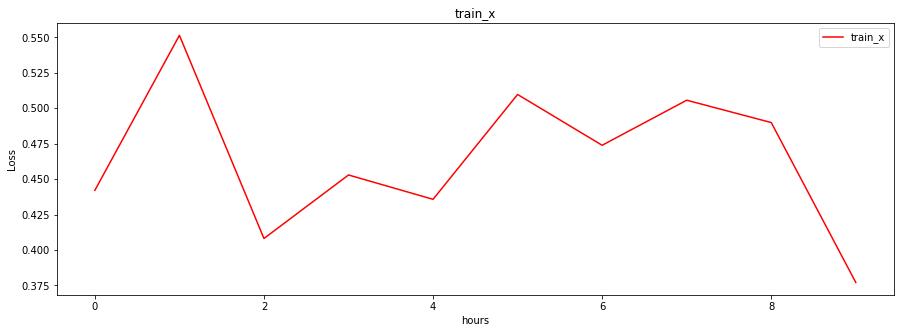

In [21]:
print(data_training_array_scaled.shape)
print(data_training_array_scaled[:10,12])
plt.figure(figsize=(15,5))
plt.plot(data_training_array_scaled[:10,12], color = 'red', label = 'train_x')
plt.title('train_x')
plt.xlabel('hours')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [22]:
data_training_y[:10]

array([[0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.]], dtype=float32)

(82012, 18)


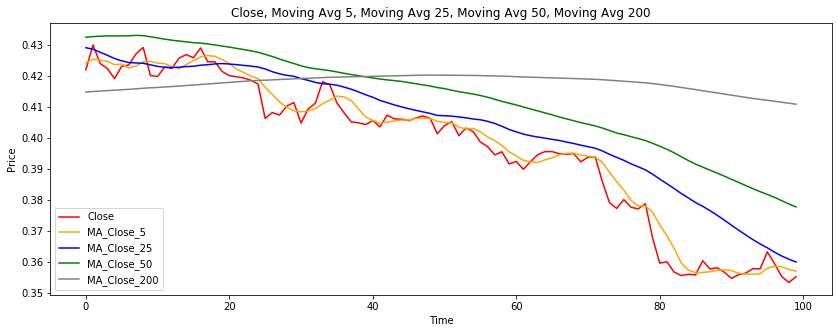

In [23]:
INICIO = 0
FIN = 100

IDX_Close = DF_Full.columns.get_loc("Close")
IDX_MA_Close_5 = DF_Full.columns.get_loc("MA_Close_5")
IDX_MA_Close_25 = DF_Full.columns.get_loc("MA_Close_25")
IDX_MA_Close_50 = DF_Full.columns.get_loc("MA_Close_50")
IDX_MA_Close_200 = DF_Full.columns.get_loc("MA_Close_200")

print(data_training_array_scaled.shape)
plt.figure(figsize=(14,5))
pyplot.plot(data_training_array_scaled[INICIO:FIN,IDX_Close], color = 'red', label = 'Close')
pyplot.plot(data_training_array_scaled[INICIO:FIN,IDX_MA_Close_5], color = 'orange', label = 'MA_Close_5')
pyplot.plot(data_training_array_scaled[INICIO:FIN,IDX_MA_Close_25], color = 'blue', label = 'MA_Close_25')
pyplot.plot(data_training_array_scaled[INICIO:FIN,IDX_MA_Close_50], color = 'green', label = 'MA_Close_50')
pyplot.plot(data_training_array_scaled[INICIO:FIN,IDX_MA_Close_200], color = 'gray', label = 'MA_Close_200')
plt.title('Close, Moving Avg 5, Moving Avg 25, Moving Avg 50, Moving Avg 200')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

(82012, 18)


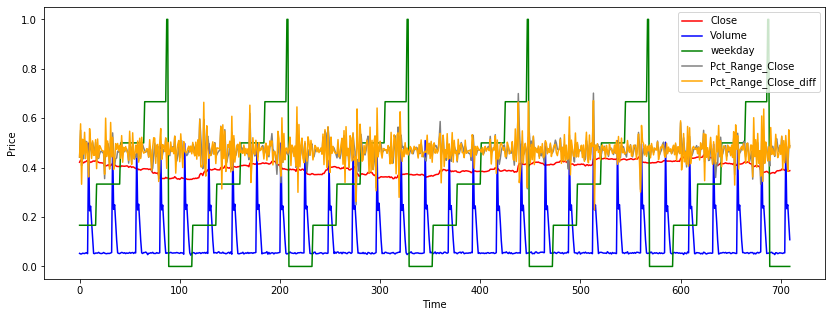

In [24]:
print(data_training_array_scaled.shape)
INICIO = 0
FIN = 710


IDX_Close = DF_Full.columns.get_loc("Close")
IDX_Volume = DF_Full.columns.get_loc("Volume")
IDX_weekday = DF_Full.columns.get_loc("weekday")
IDX_Pct_Range_Close = DF_Full.columns.get_loc("Pct_Range_Close")
IDX_Pct_Range_Close_diff = DF_Full.columns.get_loc("Pct_Range_Close_diff")

plt.figure(figsize=(14,5))
pyplot.plot(data_training_array_scaled[INICIO:FIN,IDX_Close], color = 'red', label = 'Close')
pyplot.plot(data_training_array_scaled[INICIO:FIN,IDX_Volume], color = 'blue', label = 'Volume')
pyplot.plot(data_training_array_scaled[INICIO:FIN,IDX_weekday], color = 'green', label = 'weekday')
pyplot.plot(data_training_array_scaled[INICIO:FIN,IDX_Pct_Range_Close], color = 'gray', label = 'Pct_Range_Close')
pyplot.plot(data_training_array_scaled[INICIO:FIN,IDX_Pct_Range_Close_diff], color = 'orange', label = 'Pct_Range_Close_diff')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

(82012, 18)


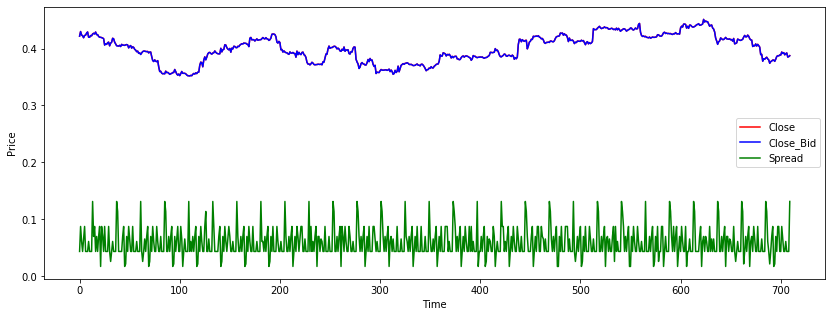

In [25]:
print(data_training_array_scaled.shape)
INICIO = 0
FIN = 710


IDX_Close = DF_Full.columns.get_loc("Close")
IDX_Close_Bid = DF_Full.columns.get_loc("Close_Bid")
IDX_Spread = DF_Full.columns.get_loc("Spread")

plt.figure(figsize=(14,5))
pyplot.plot(data_training_array_scaled[INICIO:FIN,IDX_Close], color = 'red', label = 'Close')
pyplot.plot(data_training_array_scaled[INICIO:FIN,IDX_Close_Bid], color = 'blue', label = 'Close_Bid')
pyplot.plot(data_training_array_scaled[INICIO:FIN,IDX_Spread], color = 'green', label = 'Spread')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

In [26]:
data_training_y

array([[0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.],
       ...,
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]], dtype=float32)

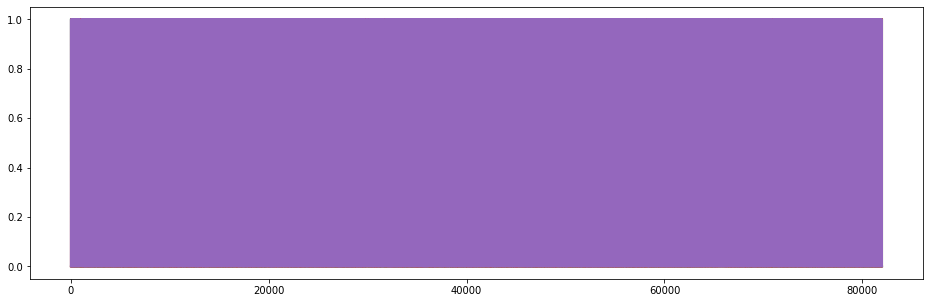

In [27]:
# Target para el entrenamiento
pyplot.figure(figsize=(16,5))
pyplot.plot(data_training_y)

In [28]:
X_train = []
y_train = []
for i in range(RANGE, data_training_array_scaled.shape[0]):
    X_train.append(data_training_array_scaled[i-RANGE:i])
    y_train.append(data_training_y[i])

X_train_np, y_train_np = np.array(X_train), np.array(y_train)

print(X_train_np.shape)
print(y_train_np.shape)

(81988, 24, 18)
(81988, 5)


In [29]:

#Obtener los ultimos valores de Train para agregarlos a Val DF
# APPEND DE X
last_range_training_x = data_training.tail(RANGE)
print(last_range_training_x.shape)
print(data_val.shape)
data_val_x1 = last_range_training_x.append(data_val, ignore_index = True)
data_val_x1.shape
print(data_val_x1.head)

(24, 18)
(0, 18)
<bound method NDFrame.head of        Open     High      Low    Close      Volume  Open_Bid  High_Bid  \
0   1.05579  1.05608  1.05382  1.05544  15157.6602   1.05578   1.05607   
1   1.05543  1.05645  1.05499  1.05533  12418.3496   1.05541   1.05642   
2   1.05535  1.05593  1.05393  1.05467  13389.0801   1.05534   1.05592   
3   1.05468  1.05509  1.05378  1.05462  11270.7197   1.05466   1.05507   
4   1.05462  1.05562  1.05403  1.05524  10993.2100   1.05460   1.05560   
5   1.05526  1.05696  1.05478  1.05685  18754.9199   1.05524   1.05695   
6   1.05686  1.05853  1.05624  1.05797  20450.3496   1.05685   1.05850   
7   1.05796  1.05881  1.05714  1.05813  17103.7305   1.05794   1.05879   
8   1.05812  1.05953  1.05760  1.05938  16883.3398   1.05811   1.05952   
9   1.05941  1.05944  1.05754  1.05855  17465.2891   1.05940   1.05942   
10  1.05854  1.05890  1.05639  1.05665  12595.7305   1.05852   1.05887   
11  1.05671  1.05737  1.05642  1.05699  10315.4404   1.05669   1.

In [30]:
last_range_train_y = data_training_y[-RANGE:]
last_range_train_y

array([[1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]], dtype=float32)

In [31]:
last_range_train_y.shape

(24, 5)

In [32]:
#Append de los datos de Train al DF de Val en Y
last_range_train_y = data_training_y[-RANGE:]
print(last_range_train_y.shape)
print(data_val_y.shape)
data_val_y1 = np.concatenate((last_range_train_y,data_val_y))
print(data_val_y1.shape)
print(data_val_y1[:10])

(24, 5)
(0, 5)
(24, 5)
[[1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0.]]


In [33]:
data_val_x2 = scaler.transform(data_val_x1)
data_val_x2.shape
print(data_val_x2[:10])

[[0.0356802  0.03358084 0.03500478 0.03500371 0.03083355 0.03570671
  0.03360559 0.03500602 0.0349947  0.02524952 0.00877193 0.5
  0.4613301  0.48042361 0.03393754 0.02706381 0.025556   0.02996571]
 [0.035044   0.03423341 0.03707638 0.03480934 0.02526114 0.03505268
  0.03422301 0.0370777  0.03481796 0.02323367 0.00438596 0.5
  0.4667865  0.47663524 0.03346812 0.02738471 0.02542816 0.02990296]
 [0.03490263 0.03331628 0.03519955 0.03364314 0.02723584 0.03492894
  0.03334098 0.0352185  0.03365147 0.0253558  0.00438596 0.5
  0.45477503 0.45974155 0.03290267 0.02770418 0.02531513 0.0298347 ]
 [0.03371859 0.03183478 0.03493396 0.03355479 0.02292658 0.03372693
  0.03184152 0.03493519 0.03354542 0.01854409 0.00877193 0.5
  0.46809588 0.48424119 0.03220208 0.02797207 0.02524652 0.02977085]
 [0.03361255 0.03276954 0.03537661 0.03465032 0.02236206 0.03362087
  0.03277647 0.03539557 0.03465889 0.01647893 0.00438596 0.5
  0.48273753 0.48551857 0.03200293 0.02830229 0.02528155 0.02970966]
 [0.034743

In [34]:
X_val = []
y_val = []
for i in range(RANGE, data_val_x2.shape[0]):
    X_val.append(data_val_x2[i-RANGE:i])
    y_val.append(data_val_y1[i])

X_val_np = np.array(X_val)
y_val_np = np.array(y_val)
print(X_val_np.shape)
print(y_val_np.shape)

(0,)
(0,)


In [35]:

#Obtener los ultimos valores de Val para agregarlos a TEST DF
# Append en X
last_range_data_training_x = data_training.tail(RANGE)
print(last_range_data_training_x.shape)
print(data_test.shape)
data_test_x1 = last_range_data_training_x.append(data_test, ignore_index = True)
data_test_x1.shape


(24, 18)
(20303, 18)


(20327, 18)

In [36]:
#Append de los datos de Val al DF de Test de Y
last_range_training_y = data_training_y[-RANGE:,:]
print(last_range_training_y.shape)
print(data_test_y.shape)
data_test_y1 = np.concatenate((last_range_training_y,data_test_y))
print(data_test_y1.shape)

(24, 5)
(20303, 5)
(20327, 5)


In [37]:
data_test_x2 = scaler.transform(data_test_x1)
data_test_x2.shape
print(data_test_x2[:10])

[[0.0356802  0.03358084 0.03500478 0.03500371 0.03083355 0.03570671
  0.03360559 0.03500602 0.0349947  0.02524952 0.00877193 0.5
  0.4613301  0.48042361 0.03393754 0.02706381 0.025556   0.02996571]
 [0.035044   0.03423341 0.03707638 0.03480934 0.02526114 0.03505268
  0.03422301 0.0370777  0.03481796 0.02323367 0.00438596 0.5
  0.4667865  0.47663524 0.03346812 0.02738471 0.02542816 0.02990296]
 [0.03490263 0.03331628 0.03519955 0.03364314 0.02723584 0.03492894
  0.03334098 0.0352185  0.03365147 0.0253558  0.00438596 0.5
  0.45477503 0.45974155 0.03290267 0.02770418 0.02531513 0.0298347 ]
 [0.03371859 0.03183478 0.03493396 0.03355479 0.02292658 0.03372693
  0.03184152 0.03493519 0.03354542 0.01854409 0.00877193 0.5
  0.46809588 0.48424119 0.03220208 0.02797207 0.02524652 0.02977085]
 [0.03361255 0.03276954 0.03537661 0.03465032 0.02236206 0.03362087
  0.03277647 0.03539557 0.03465889 0.01647893 0.00438596 0.5
  0.48273753 0.48551857 0.03200293 0.02830229 0.02528155 0.02970966]
 [0.034743

In [38]:
X_test = []
y_test = []
for i in range(RANGE, data_test_x2.shape[0]):
    X_test.append(data_test_x2[i-RANGE:i])
    y_test.append(data_test_y1[i])

X_test_np = np.array(X_test)
y_test_np = np.array(y_test)
print(X_test_np.shape)
print(y_test_np.shape)

(20303, 24, 18)
(20303, 5)


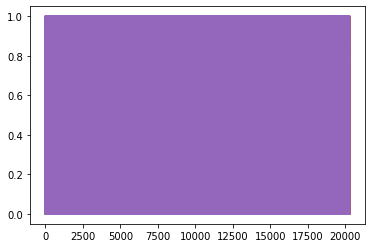

In [39]:
# Y del dataset de pruebas
pyplot.plot(y_test_np)

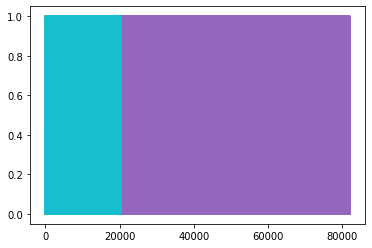

In [40]:

# Y de Val y Test comparados
pyplot.plot(y_train_np)
pyplot.plot(y_test_np)
pyplot.plot(y_val_np)


In [41]:
x_shape = X_train_np.shape[1]
print(x_shape)
y_shape = X_train_np.shape[2]
print(y_shape)

24
18


In [50]:
def baseline_model():
    model = Sequential()
    model.add(LSTM(units = RANGE, activation = 'relu', return_sequences = True, input_shape = (x_shape, y_shape)))
    model.add(LSTM(units = 5, activation = 'softmax'))
    model.compile(optimizer='adam', loss = 'categorical_crossentropy', metrics=["acc"])
    #model.summary()
    return model

In [51]:
estimator = KerasClassifier(build_fn=baseline_model, epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=1)
kfold = KFold(n_splits=10, shuffle=True)

In [ ]:
results = cross_val_score(estimator, X_train_np, y_train_np, cv=kfold)

Epoch 1/100
2460/2460 [==============================] - 56s 23ms/step - loss: 1.5934 - acc: 0.2594
Epoch 2/100
2460/2460 [==============================] - 56s 23ms/step - loss: 1.5812 - acc: 0.2603
Epoch 3/100
2460/2460 [==============================] - 56s 23ms/step - loss: 1.5750 - acc: 0.2627
Epoch 4/100
2460/2460 [==============================] - 56s 23ms/step - loss: 1.5721 - acc: 0.2645
Epoch 5/100
2460/2460 [==============================] - 56s 23ms/step - loss: 1.5661 - acc: 0.2721
Epoch 6/100
2460/2460 [==============================] - 56s 23ms/step - loss: 1.5574 - acc: 0.2827
Epoch 7/100
2460/2460 [==============================] - 57s 23ms/step - loss: 1.5524 - acc: 0.2845
Epoch 8/100
2460/2460 [==============================] - 56s 23ms/step - loss: 1.5496 - acc: 0.2869
Epoch 9/100
2460/2460 [==============================] - 56s 23ms/step - loss: 1.5474 - acc: 0.2881
Epoch 10/100
2460/2460 [==============================] - 59s 24ms/step - loss: 1.5453 - acc: 0.2888

2460/2460 [==============================] - 73s 30ms/step - loss: 1.5147 - acc: 0.3054
Epoch 83/100
2460/2460 [==============================] - 60s 25ms/step - loss: 1.5147 - acc: 0.3069
Epoch 84/100
2460/2460 [==============================] - 64s 26ms/step - loss: 1.5143 - acc: 0.3081
Epoch 85/100
2460/2460 [==============================] - 59s 24ms/step - loss: 1.5139 - acc: 0.3089
Epoch 86/100
2460/2460 [==============================] - 64s 26ms/step - loss: 1.5140 - acc: 0.3080
Epoch 87/100
2460/2460 [==============================] - 62s 25ms/step - loss: 1.5135 - acc: 0.3074
Epoch 88/100
2460/2460 [==============================] - 64s 26ms/step - loss: 1.5135 - acc: 0.3092 0s - loss: 1.5138 -
Epoch 89/100
2460/2460 [==============================] - 59s 24ms/step - loss: 1.5134 - acc: 0.3080
Epoch 90/100
2460/2460 [==============================] - 61s 25ms/step - loss: 1.5128 - acc: 0.3082
Epoch 91/100
2460/2460 [==============================] - 62s 25ms/step - loss: 1.51

2460/2460 [==============================] - 56s 23ms/step - loss: 1.5241 - acc: 0.3014
Epoch 63/100
2460/2460 [==============================] - 52s 21ms/step - loss: 1.5238 - acc: 0.3004
Epoch 64/100
2460/2460 [==============================] - 52s 21ms/step - loss: 1.5243 - acc: 0.3013 1s - lo
Epoch 65/100
2460/2460 [==============================] - 52s 21ms/step - loss: 1.5240 - acc: 0.3018
Epoch 66/100
2460/2460 [==============================] - 54s 22ms/step - loss: 1.5233 - acc: 0.3025
Epoch 67/100
2460/2460 [==============================] - 55s 22ms/step - loss: 1.5237 - acc: 0.3012
Epoch 68/100
2460/2460 [==============================] - 54s 22ms/step - loss: 1.5233 - acc: 0.3018
Epoch 69/100
2460/2460 [==============================] - 55s 23ms/step - loss: 1.5235 - acc: 0.3022
Epoch 70/100
2460/2460 [==============================] - 59s 24ms/step - loss: 1.5232 - acc: 0.3027
Epoch 71/100
2460/2460 [==============================] - 54s 22ms/step - loss: 1.5231 - acc: 0.

2460/2460 [==============================] - 74s 30ms/step - loss: 1.5290 - acc: 0.2998
Epoch 42/100
2460/2460 [==============================] - 74s 30ms/step - loss: 1.5285 - acc: 0.2989
Epoch 43/100
2460/2460 [==============================] - 64s 26ms/step - loss: 1.5281 - acc: 0.2994
Epoch 44/100
2460/2460 [==============================] - 69s 28ms/step - loss: 1.5279 - acc: 0.2979
Epoch 45/100
2460/2460 [==============================] - 66s 27ms/step - loss: 1.5283 - acc: 0.2997
Epoch 46/100
2460/2460 [==============================] - 67s 27ms/step - loss: 1.5275 - acc: 0.2998
Epoch 47/100
2460/2460 [==============================] - 67s 27ms/step - loss: 1.5269 - acc: 0.2998
Epoch 48/100
2460/2460 [==============================] - 68s 27ms/step - loss: 1.5264 - acc: 0.2998
Epoch 49/100
2460/2460 [==============================] - 65s 26ms/step - loss: 1.5263 - acc: 0.3003
Epoch 50/100
2460/2460 [==============================] - 64s 26ms/step - loss: 1.5276 - acc: 0.2989
Epo

2460/2460 [==============================] - 50s 20ms/step - loss: 1.5349 - acc: 0.2955
Epoch 22/100
2460/2460 [==============================] - 50s 20ms/step - loss: 1.5346 - acc: 0.2967
Epoch 23/100
2460/2460 [==============================] - 50s 20ms/step - loss: 1.5338 - acc: 0.2953
Epoch 24/100
2460/2460 [==============================] - 50s 20ms/step - loss: 1.5331 - acc: 0.2955
Epoch 25/100
2460/2460 [==============================] - 50s 20ms/step - loss: 1.5325 - acc: 0.2983
Epoch 26/100
2460/2460 [==============================] - 50s 20ms/step - loss: 1.5323 - acc: 0.2979
Epoch 27/100
2460/2460 [==============================] - 50s 20ms/step - loss: 1.5315 - acc: 0.2989
Epoch 28/100
2460/2460 [==============================] - 50s 21ms/step - loss: 1.5312 - acc: 0.2994
Epoch 29/100
2460/2460 [==============================] - 50s 20ms/step - loss: 1.5307 - acc: 0.2983
Epoch 30/100
2460/2460 [==============================] - 50s 20ms/step - loss: 1.5305 - acc: 0.2985
Epo

2460/2460 [==============================] - 56s 23ms/step - loss: 1.5940 - acc: 0.2593
Epoch 2/100
2460/2460 [==============================] - 53s 22ms/step - loss: 1.5881 - acc: 0.2586
Epoch 3/100
2460/2460 [==============================] - 53s 22ms/step - loss: 1.5797 - acc: 0.2617
Epoch 4/100
2460/2460 [==============================] - 54s 22ms/step - loss: 1.5731 - acc: 0.2675
Epoch 5/100
2460/2460 [==============================] - 54s 22ms/step - loss: 1.5676 - acc: 0.2732
Epoch 6/100
2460/2460 [==============================] - 54s 22ms/step - loss: 1.5597 - acc: 0.2812
Epoch 7/100
2460/2460 [==============================] - 53s 22ms/step - loss: 1.5538 - acc: 0.2847
Epoch 8/100
2460/2460 [==============================] - 53s 22ms/step - loss: 1.5512 - acc: 0.2877
Epoch 9/100
2460/2460 [==============================] - 53s 22ms/step - loss: 1.5496 - acc: 0.2874
Epoch 10/100
2460/2460 [==============================] - 59s 24ms/step - loss: 1.5478 - acc: 0.2893
Epoch 11/10

2460/2460 [==============================] - 56s 23ms/step - loss: 1.5181 - acc: 0.3045
Epoch 82/100
2460/2460 [==============================] - 62s 25ms/step - loss: 1.5179 - acc: 0.3045
Epoch 83/100
2460/2460 [==============================] - 60s 25ms/step - loss: 1.5185 - acc: 0.3040
Epoch 84/100
2460/2460 [==============================] - 61s 25ms/step - loss: 1.5177 - acc: 0.3050
Epoch 85/100
2460/2460 [==============================] - 57s 23ms/step - loss: 1.5175 - acc: 0.3040
Epoch 86/100
2460/2460 [==============================] - 57s 23ms/step - loss: 1.5169 - acc: 0.3045
Epoch 87/100
2460/2460 [==============================] - 55s 23ms/step - loss: 1.5172 - acc: 0.3039
Epoch 88/100
2460/2460 [==============================] - 59s 24ms/step - loss: 1.5167 - acc: 0.3052
Epoch 89/100
2460/2460 [==============================] - 60s 24ms/step - loss: 1.5167 - acc: 0.3045
Epoch 90/100
2460/2460 [==============================] - 57s 23ms/step - loss: 1.5164 - acc: 0.3061
Epo

2460/2460 [==============================] - 50s 20ms/step - loss: 1.5162 - acc: 0.3038
Epoch 62/100
2460/2460 [==============================] - 50s 20ms/step - loss: 1.5156 - acc: 0.3057
Epoch 63/100
2460/2460 [==============================] - 50s 20ms/step - loss: 1.5484 - acc: 0.2920
Epoch 64/100
2460/2460 [==============================] - 50s 20ms/step - loss: 1.5350 - acc: 0.2942
Epoch 65/100
2460/2460 [==============================] - 50s 20ms/step - loss: 1.5258 - acc: 0.2999
Epoch 66/100
2460/2460 [==============================] - 50s 20ms/step - loss: 1.5195 - acc: 0.3035
Epoch 67/100
2460/2460 [==============================] - 50s 20ms/step - loss: 1.5167 - acc: 0.3049
Epoch 68/100
2460/2460 [==============================] - 51s 21ms/step - loss: 1.5163 - acc: 0.3047
Epoch 69/100
2460/2460 [==============================] - 51s 21ms/step - loss: 1.5278 - acc: 0.3005
Epoch 70/100
2460/2460 [==============================] - 50s 20ms/step - loss: 1.5756 - acc: 0.2692
Epo

2460/2460 [==============================] - 48s 19ms/step - loss: 1.5269 - acc: 0.2993
Epoch 42/100
2460/2460 [==============================] - 48s 19ms/step - loss: 1.5263 - acc: 0.3012
Epoch 43/100
2460/2460 [==============================] - 48s 20ms/step - loss: 1.5264 - acc: 0.2991
Epoch 44/100
2460/2460 [==============================] - 48s 20ms/step - loss: 1.5260 - acc: 0.2997
Epoch 45/100
2460/2460 [==============================] - 48s 19ms/step - loss: 1.5257 - acc: 0.2995
Epoch 46/100
2460/2460 [==============================] - 48s 19ms/step - loss: 1.5251 - acc: 0.2997
Epoch 47/100
2460/2460 [==============================] - 48s 20ms/step - loss: 1.5249 - acc: 0.2997
Epoch 48/100
2460/2460 [==============================] - 48s 19ms/step - loss: 1.5245 - acc: 0.3008
Epoch 49/100
2460/2460 [==============================] - 49s 20ms/step - loss: 1.5244 - acc: 0.3003
Epoch 50/100
2460/2460 [==============================] - 51s 21ms/step - loss: 1.5245 - acc: 0.3009
Epo

2460/2460 [==============================] - 50s 20ms/step - loss: 1.5337 - acc: 0.2960
Epoch 22/100
2460/2460 [==============================] - 50s 20ms/step - loss: 1.5332 - acc: 0.2971
Epoch 23/100
2460/2460 [==============================] - 50s 20ms/step - loss: 1.5320 - acc: 0.2968
Epoch 24/100
2460/2460 [==============================] - 51s 21ms/step - loss: 1.5312 - acc: 0.2980
Epoch 25/100
2460/2460 [==============================] - 50s 20ms/step - loss: 1.5308 - acc: 0.2992
Epoch 26/100
2460/2460 [==============================] - 50s 20ms/step - loss: 1.5303 - acc: 0.2986
Epoch 27/100
2460/2460 [==============================] - 50s 20ms/step - loss: 1.5297 - acc: 0.2999
Epoch 28/100
2460/2460 [==============================] - 50s 20ms/step - loss: 1.5283 - acc: 0.2996
Epoch 29/100
2460/2460 [==============================] - 2196s 893ms/step - loss: 1.5282 - acc: 0.3005
Epoch 30/100
2460/2460 [==============================] - 48s 19ms/step - loss: 1.5275 - acc: 0.3017


2460/2460 [==============================] - 50s 20ms/step - loss: 1.5948 - acc: 0.2588
Epoch 2/100
2460/2460 [==============================] - 49s 20ms/step - loss: 1.5885 - acc: 0.2590
Epoch 3/100
2460/2460 [==============================] - 49s 20ms/step - loss: 1.5791 - acc: 0.2593
Epoch 4/100
2460/2460 [==============================] - 48s 20ms/step - loss: 1.5746 - acc: 0.2612
Epoch 5/100
2460/2460 [==============================] - 49s 20ms/step - loss: 1.5672 - acc: 0.2692
Epoch 6/100
2460/2460 [==============================] - 49s 20ms/step - loss: 1.5588 - acc: 0.2796
Epoch 7/100
2460/2460 [==============================] - 49s 20ms/step - loss: 1.5543 - acc: 0.2835
Epoch 8/100
2460/2460 [==============================] - 53s 22ms/step - loss: 1.5521 - acc: 0.2851
Epoch 9/100
2460/2460 [==============================] - 51s 21ms/step - loss: 1.5497 - acc: 0.2868
Epoch 10/100
2460/2460 [==============================] - 50s 20ms/step - loss: 1.5478 - acc: 0.2882
Epoch 11/10

2460/2460 [==============================] - 61s 25ms/step - loss: 1.5180 - acc: 0.3049
Epoch 82/100
2460/2460 [==============================] - 58s 24ms/step - loss: 1.5183 - acc: 0.3047
Epoch 83/100
2460/2460 [==============================] - 54s 22ms/step - loss: 1.5178 - acc: 0.3061
Epoch 84/100
2460/2460 [==============================] - 60s 24ms/step - loss: 1.5177 - acc: 0.3067
Epoch 85/100
2460/2460 [==============================] - 59s 24ms/step - loss: 1.5177 - acc: 0.3046
Epoch 86/100
2460/2460 [==============================] - 56s 23ms/step - loss: 1.5175 - acc: 0.3054
Epoch 87/100
2460/2460 [==============================] - 68s 28ms/step - loss: 1.5174 - acc: 0.3056
Epoch 88/100
2460/2460 [==============================] - 65s 26ms/step - loss: 1.5168 - acc: 0.3046
Epoch 89/100
2460/2460 [==============================] - 86s 35ms/step - loss: 1.5173 - acc: 0.3053
Epoch 90/100
2460/2460 [==============================] - 78s 32ms/step - loss: 1.5189 - acc: 0.3054
Epo

2460/2460 [==============================] - 64s 26ms/step - loss: 1.5150 - acc: 0.3048
Epoch 62/100
2460/2460 [==============================] - 56s 23ms/step - loss: 1.5155 - acc: 0.3061
Epoch 63/100
2460/2460 [==============================] - 57s 23ms/step - loss: 1.5153 - acc: 0.3053
Epoch 64/100
2280/2460 [==========================>...] - ETA: 4s - loss: 1.5153 - acc: 0.3049

In [441]:
print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Baseline: nan% (nan%)


In [442]:
pwd = os.getcwd()
source_data = os.path.join(pwd, r'../../../Models/2020/LSTM/')
print(source_data)

/Users/marami3/Documents/ITESO/IDI4/forex_prediction/Jupyter Notebooks/IDI4/models_clasification/../../../Models/2020/LSTM/


In [443]:
#Model check pointer para almacenar el modelo cada epoca

#checkpointer = ModelCheckpoint(filepath=source_data + '/model-{epoch:02d}.hdf5', verbose=1)

In [444]:
#plot Train primeros [Row, Profundidad RANGE, Columna]
plot_train_x = X_train_np[:10,:1,12]
print(plot_train_x)

[[0.44209275]
 [0.55147565]
 [0.40809816]
 [0.45292671]
 [0.4357379 ]
 [0.5097497 ]
 [0.47388822]
 [0.50569431]
 [0.48993864]
 [0.37706861]]


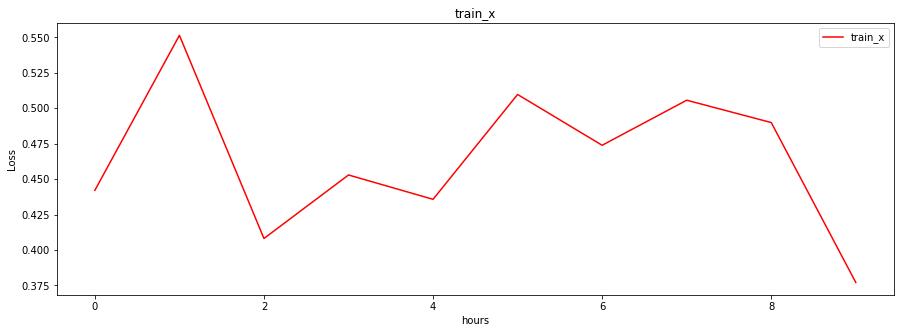

In [445]:
# Imprimir primeros 10 PCT_RANGE
plt.figure(figsize=(15,5))
plt.plot(plot_train_x, color = 'red', label = 'train_x')
plt.title('train_x')
plt.xlabel('hours')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [446]:
y_train_np[:10]

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1.]], dtype=float32)

In [447]:
#%%time
#history = regressior.fit(X_train_np, y_train_np, epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=[checkpointer])
#history = regressior.fit(X_train_np, y_train_np, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(X_val_np, y_val_np))
#history = regressior.fit(X_train_np, y_train_np, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(X_val_np, y_val_np), callbacks=[checkpointer], shuffle=True)
#history = regressior.fit(X_train_np, y_train_np, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(X_val_np, y_val_np),shuffle=True)
#history = regressior.fit(X_train_np, y_train_np, epochs=EPOCHS, batch_size=BATCH_SIZE)

#history = model.fit(X_train_np, y_train_np, epochs=EPOCHS, batch_size=BATCH_SIZE)





In [448]:
file_name = MODEL_NAME + '_' + FRECUENCIA + '_' + str(NUM_FEATURES) + 'F_' + TARGET_NAME + "_"+ ID + '.hdf5'
print(file_name)



C-LSTM_1H_23F_Class_01.hdf5


In [449]:
model.save(source_data + file_name)

In [450]:
#print(history.history.keys())

In [451]:
#PLOT MSE MAE

#plt.figure(figsize=(5,5))
#plt.plot(history.history['loss'], color = 'red', label = 'loss')
#plt.title('Loss Model')
#plt.xlabel('Epochs')
#plt.ylabel('Loss')
#plt.legend()
#plt.show()

In [452]:
#PLOT MSE MAE
#plt.figure(figsize=(5,5))
#plt.plot(history.history['mean_squared_error'][:], color = 'green', label = 'MAPE')
#plt.title('Loss Model')
#plt.xlabel('Epochs')
#plt.ylabel('Loss - MSE')
#plt.legend()
#plt.show()


In [453]:
#Load Model
filepath = os.path.join(source_data, file_name)
print(filepath)
model = tf.keras.models.load_model(filepath)

/Users/marami3/Documents/ITESO/IDI4/forex_prediction/Jupyter Notebooks/IDI4/models_clasification/../../../Models/2020/LSTM/C-LSTM_1H_23F_Class_01.hdf5


In [454]:
y_test_pred = model.predict(X_test_np)
y_test_pred.shape



(20303, 5)

In [455]:
ID = 10
print(y_test_pred[:ID])
print(y_test_np[:ID])

[[0.10281266 0.0864735  0.1009761  0.09487896 0.10050533]
 [0.10277134 0.08640306 0.10099005 0.09490548 0.10057917]
 [0.10265286 0.08646973 0.10100446 0.09497523 0.10072247]
 [0.10273956 0.08625234 0.10101514 0.0949321  0.1006471 ]
 [0.10269718 0.0862505  0.10102911 0.09497415 0.10074635]
 [0.10273848 0.08614267 0.10102379 0.0949586  0.10072093]
 [0.10269397 0.08615518 0.10101251 0.09498683 0.10079844]
 [0.10269824 0.08613384 0.10102257 0.09498759 0.10082571]
 [0.10253952 0.08630929 0.10108978 0.09511268 0.10099436]
 [0.10263582 0.08617967 0.10109355 0.09505823 0.10089196]]
[[0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]]


In [456]:

uniques, ids = np.unique(arr, return_inverse=True)
uniques[y_test_pred[:1].argmax(1)]

NameError: name 'arr' is not defined

In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test_np, y_test_pred)

In [ ]:
y_test_np.shape

In [ ]:
y_train_pred = model.predict(X_train_np)
y_train_pred.shape


In [ ]:
INICIO = 0
FIN = 280
print(y_test_np.shape)
print(y_test_pred.shape)
# Visualising the results
plt.figure(figsize=(14,5))
plt.plot(y_test_np[INICIO:FIN], color = 'red', label = 'Real')
plt.plot(y_test_pred[INICIO:FIN], color = 'blue', label = 'Predicted')
plt.title('Prediction - Test dataset')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()


In [ ]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [ ]:
print('Test MAE:', mean_absolute_error(y_test_np, y_test_pred))#Mean Absolute Error
print('Test RMSE:',np.sqrt(mean_squared_error(y_test_np, y_test_pred)))#Root Mean Squared Error
print('Test MSE:',mean_squared_error(y_test_np, y_test_pred))#Mean Squared Error
print('Test MAPE:',mean_absolute_percentage_error(y_test_np, y_test_pred))#Mean Absolute Percentaje Error


In [ ]:
print(y_train_np.shape)
INICIO = 0
FIN = 127
# Visualising the results
plt.figure(figsize=(14,5))
plt.plot(y_train_np[INICIO:FIN], color = 'red', label = 'Real')
plt.plot(y_train_pred[INICIO:FIN], color = 'blue', label = 'Predicted')
plt.title('Prediction - Training dataset')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()


In [ ]:
print('Train MAE:', mean_absolute_error(y_train_np, y_train_pred))#Mean Absolute Error
print('Train RMSE:',np.sqrt(mean_squared_error(y_train_np, y_train_pred)))#Root Mean Squared Error
print('Train MSE:',mean_squared_error(y_train_np, y_train_pred))#Mean Squared Error
print('Test MAPE:',mean_absolute_percentage_error(y_train_np, y_train_pred))#Mean Absolute Percentaje Error
